# End-to-End Machine Learning Project

## Get the Data

### Download the Data

In [1]:
import os
import tarfile
from six.moves import urllib
import ssl
import progressbar

from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='onedork')

ssl._create_default_https_context = ssl._create_unverified_context

class ProgressBar():
    def __init__(self):
        self.pbar = None

    def __call__(self, block_num, block_size, total_size):
        if not self.pbar:
            self.pbar = progressbar.ProgressBar(maxval=total_size)
            self.pbar.start()

        downloaded = block_num * block_size
        if downloaded < total_size:
            self.pbar.update(downloaded)
        else:
            self.pbar.finish()

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    print("Downloading...")
    urllib.request.urlretrieve(housing_url, tgz_path, ProgressBar())
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
# Download data
fetch_housing_data()

Downloading...


100% |########################################################################|


In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

### Take a Quick Look at the Data Structure

In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


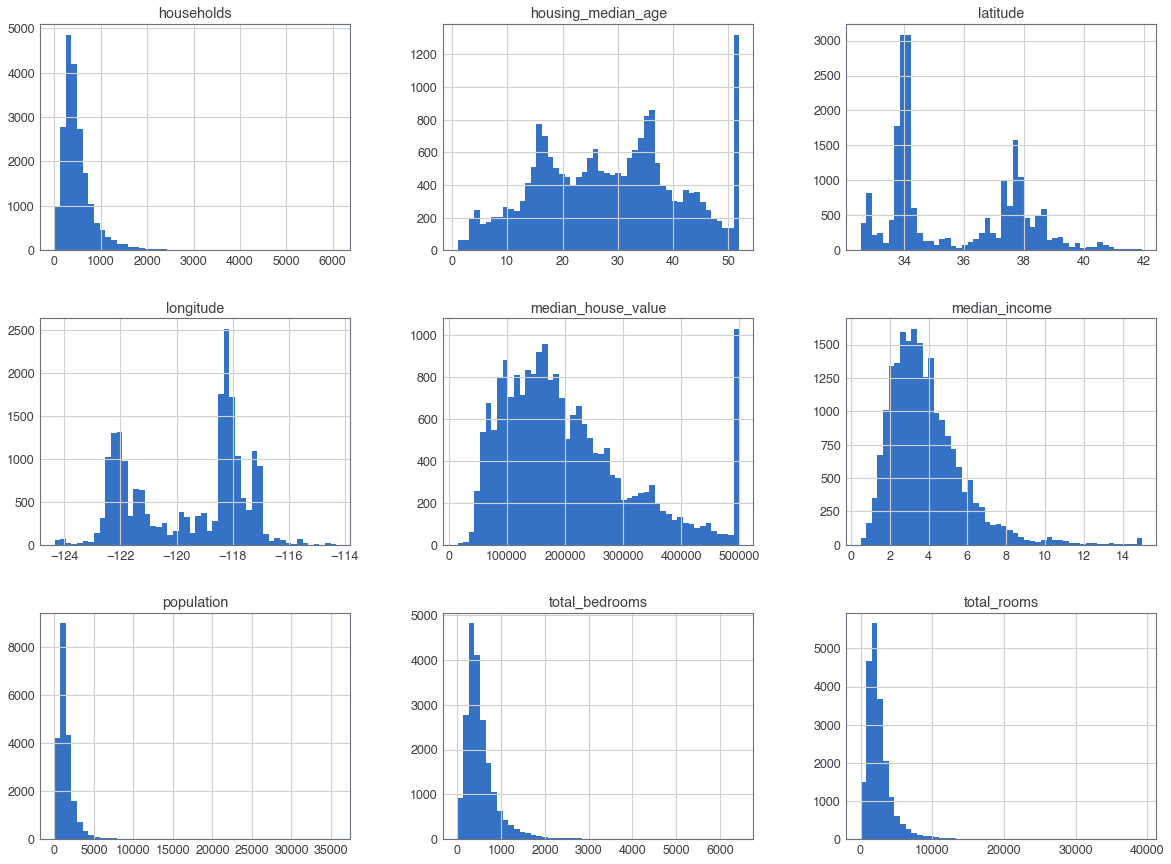

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
jtplot.style(theme='grade3')
housing.hist(bins=50, figsize=(20, 15))
plt.show()

### Create a Test Set

In [9]:
import numpy as np

""" Creating a test set is theoretically quite simple: just pick some instances
randomly, typically 20% of the dataset (or less if your dataset
is very large), and set them aside: """

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data)) # randomize indices
    test_set_size = int(len(data) * test_ratio) # calc size of test set
    test_indices = shuffled_indices[:test_set_size] # Take first items
    train_indices = shuffled_indices[test_set_size:] # Take last items
    
    return data.iloc[train_indices], data.iloc[test_indices]
    

In [10]:
# Use function above to split dataset
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

16512

In [11]:
len(test_set)

4128

In [12]:
""" But split randomize the dataset is not the best solution:
"if you run the program again, it will generate a different test set"
A possible implementation to get always the same test set below: """

from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [13]:
housing_with_id = housing.reset_index() # adds an `index` column
housing_with_id.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [14]:
# Split by index column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
len(train_set)

16512

In [15]:
len(test_set)

4128

In [16]:
# Set id column from longitude and latitude
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]

""" Obs: The location information is actually quite coarse, and as a result
many districts will have the exact same ID, so they will end up in the
same set (test or train). This introduces some unfortunate sampling bias """

housing_with_id.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122192.12
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122182.14
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-122202.15
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,-122212.15
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15


In [17]:
# Split by id column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

len(train_set)

16322

In [18]:
len(test_set)

4318

In [19]:
""" Split use sklearn lib which does pretty much 
the same thing as the function split_train_test defined earlier """
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
len(train_set)

16512

In [20]:
len(test_set)

4128

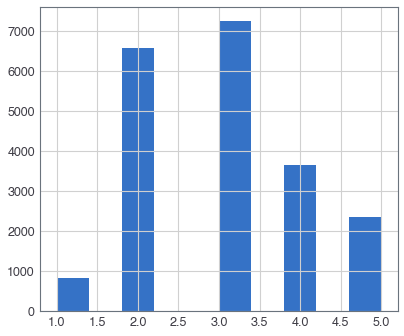

In [21]:
""" The following code uses the pd.cut() function to create an income
category attribute with 5 categories (labeled from 1 to 5):
category 1 # ranges from 0 to 1.5 (i.e., less than $15,000),
category 2 from 1.5 to 3, and so on: """

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()

In [22]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [23]:
# Remove the income_cat attribute so the data is back to its original state
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Discover and Visualize the Data to Gain Insights

### Visualizing Geographical Data

In [24]:
# Copy train set to work only with it
housing = strat_train_set.copy()

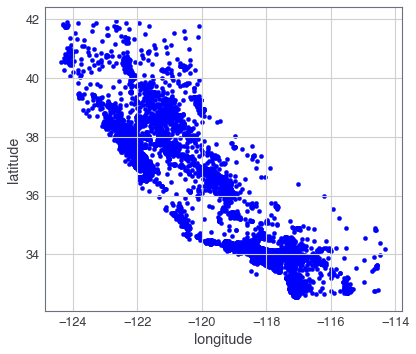

In [25]:
""" Since there is geographical information (latitude and longitude), it is a good idea to
create a scatterplot of all districts to visualize the data: """

housing.plot(kind="scatter", color="blue", x="longitude", y="latitude")

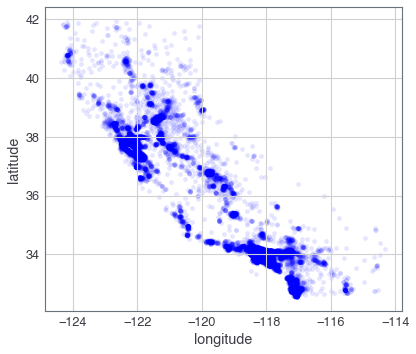

In [26]:
""" Setting the alpha option to 0.1 makes it much easier to visualize
the places where there is a high density of data points """
housing.plot(kind="scatter", color="blue", x="longitude", y="latitude", alpha="0.1")

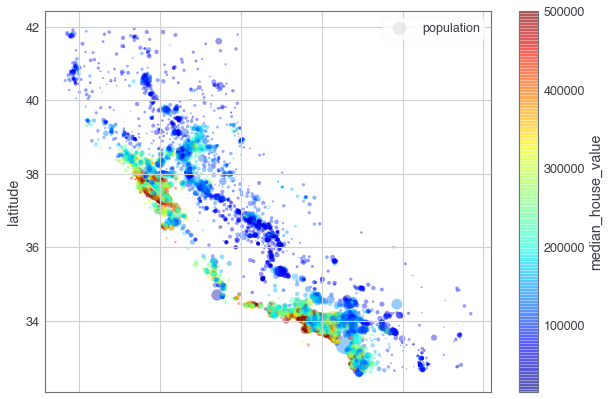

In [27]:
""" Now let’s look at the housing prices. The radius of each 
circle represents the district’s population (option s), 
and the color represents the price (option c). 
We will use a predefined color map (option cmap) called jet,
which ranges from blue (low values) to red (high prices): """

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

### Looking for Correlations

In [28]:
""" Since the dataset is not too large, you can easily compute the standard correlation
coefficient (also called Pearson’s r) between every pair of attributes using the corr()
method """

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a254805d0>,
      dtype=object)

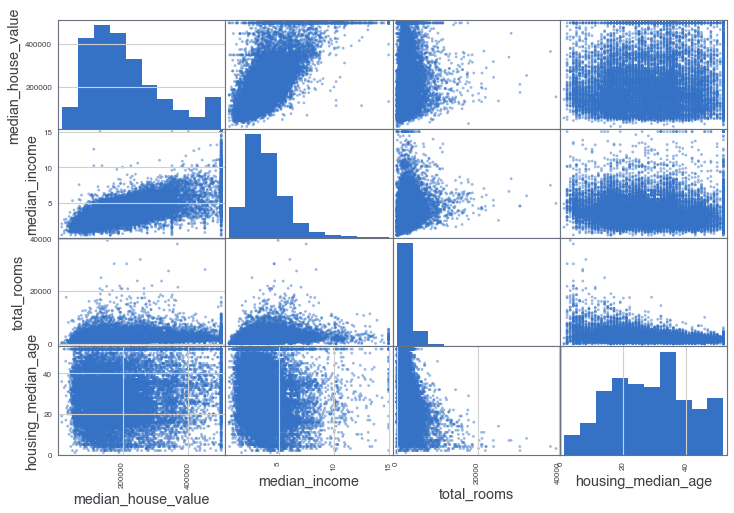

In [29]:
""" Another way to check for correlation between attributes is to use Pandas’
scatter_matrix function, which plots every numerical attribute against every other
numerical attribute. Since there are now 11 numerical attributes, you would get 11² =
121 plots, which would not fit on a page, so let’s just focus on a few promising
attributes that seem most correlated with the median housing value: """

from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

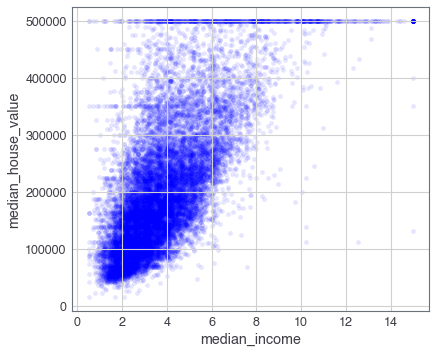

In [30]:
""" The most promising attribute to predict the median house value is the median
income, so let’s zoom in on their correlation scatterplot """

housing.plot(kind="scatter", color="blue", x="median_income", y="median_house_value", alpha=0.1)

### Experimenting with Attribute Combinations

In [31]:
# Creating new columns with more useful data
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN,4.625369,0.223852,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN,6.008850,0.159057,2.707965
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN,4.225108,0.241291,2.025974
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND,5.232295,0.200866,4.135977
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN,4.505810,0.231341,3.047847


In [32]:
# Take a look at the correlation matrix again
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## Prepare the Data for Machine Learning Algorithms

Let’s revert to a clean training set (by copying strat_train_set once again), and let’s separate the predictors and the labels since we don’t necessarily want to apply the same transformations to the predictors and the target values (note that drop() creates a copy of the data and does not affect strat_train_set):

In [33]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [34]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,INLAND
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,INLAND
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,INLAND
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,<1H OCEAN


In [35]:
housing_labels

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
           ...   
6563     240200.0
12053    113000.0
13908     97800.0
11159    225900.0
15775    500001.0
Name: median_house_value, Length: 16512, dtype: float64

### Data Cleaning

In [36]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


Most Machine Learning algorithms cannot work with missing features, so let’s create a few functions to take care of them. You noticed earlier that the total_bedrooms attribute has some missing values, so let’s fix this. You have three options:

In [37]:
# Get rid of the corresponding districts.
sample_incomplete_rows.dropna(subset=["total_bedrooms"]) # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [38]:
# Get rid of the whole attribute.
sample_incomplete_rows.drop("total_bedrooms", axis=1) # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


In [39]:
# Set the values to some value (zero, the mean, the median, etc.).
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


Scikit-Learn provides a handy class to take care of missing values: SimpleImputer. Here is how to use it. First, you need to create a SimpleImputer instance, specifying that you want to replace each attribute’s missing values with the median of that attribute:

In [40]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

Remove the text attribute because median can only be calculated on numerical attributes:

In [41]:
housing_num = housing.drop("ocean_proximity", axis=1)
housing_num
# alternatively: housing_num = housing.select_dtypes(include=np.number)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347
...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625


In [42]:
# Fit the imputer instance to the training data using the fit() method
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

The imputer has simply computed the median of each attribute and stored the result
in its statistics_ instance variable:

In [43]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Check that this is the same as manually computing the median of each attribute:

In [44]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Transform the training set:

Now you can use this "trained" imputer to transform the training set by replacing
missing values by the learned medians:

In [45]:
X = imputer.transform(housing_num)

The result is a plain NumPy array containing the transformed features. If you want to
put it back into a Pandas DataFrame, it’s simple:

In [46]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing.index)
# None value null
housing_tr[housing_tr.isnull().any(axis=1)]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income


In [47]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


In [48]:
imputer.strategy

'median'

In [49]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


### Handling Text and Categorical Attributes

Now let's preprocess the categorical input feature, `ocean_proximity`:

In [50]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


Most Machine Learning algorithms prefer to work with numbers anyway, so let’s convert these categories from text to numbers. For this, we can use Scikit-Learn’s OrdinalEncoder class:

In [51]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [52]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values. To fix this issue, a common solution is to create one binary attribute per category. Scikit-Learn provides a OneHotEncoder class to convert categorical values into one-hot vectors:

In [53]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [54]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [55]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [56]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [57]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Custom Transformers

Let's create a custom transformer to add extra attributes:

In [58]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs

array([[-121.89, 37.29, 38.0, ..., '<1H OCEAN', 4.625368731563422,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., '<1H OCEAN', 6.008849557522124,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 'NEAR OCEAN', 4.225108225108225,
        2.0259740259740258],
       ...,
       [-116.4, 34.09, 9.0, ..., 'INLAND', 6.34640522875817,
        2.742483660130719],
       [-118.01, 33.82, 31.0, ..., '<1H OCEAN', 5.50561797752809,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 'NEAR BAY', 4.843505477308295,
        1.9859154929577465]], dtype=object)

In [59]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index
)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


### Feature Scaling

### Transformation Pipelines

Now let's build a pipeline for preprocessing the numerical attributes:

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attr_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

So far, we have handled the categorical columns and the numerical columns separately. It would be more convenient to have a single transformer able to handle all columns, applying the appropriate transformations to each column.

In [61]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

In [62]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [63]:
housing_prepared.shape

(16512, 16)

For reference, here is the old solution based on a `DataFrameSelector` transformer (to just select a subset of the Pandas `DataFrame` columns), and a `FeatureUnion`:

In [64]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Now let's join all these components into a big pipeline that will preprocess both the numerical and the categorical features:

In [65]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

old_num_pipeline = Pipeline([
    ('selector', OldDataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

old_cat_pipeline = Pipeline([
    ('selector', OldDataFrameSelector(cat_attribs)),
    ('cat_encoder', OneHotEncoder(sparse=False)),
])

In [66]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", old_num_pipeline),
    ("cat_pipeline", old_cat_pipeline),
])

In [67]:
old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

The result is the same as with the `ColumnTransformer`:

In [68]:
np.allclose(housing_prepared, old_housing_prepared)

True

## Select and Train a Model

### Training and Evaluating on the Training Set

In [69]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [70]:
# let's try the full preprocessing pipeline on a few training instances
def display_predictions(model):
    some_data = housing.iloc[:5]
    some_labels = housing_labels.iloc[:5]
    some_data_prepared = full_pipeline.transform(some_data)

    print("Predictions:", model.predict(some_data_prepared))
    print("Labels:", list(some_labels))

In [71]:
display_predictions(lin_reg)

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


It works, although the predictions are not exactly accurate (e.g., the first prediction is off by close to 40%!). Let’s measure this regression model’s RMSE on the whole training set using Scikit-Learn’s mean_squared_error function:

In [72]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def display_errors(model):
    predictions = model.predict(housing_prepared)
    
    model_mse = mean_squared_error(housing_labels, predictions)
    model_rmse = np.sqrt(model_mse)
    print("mean_squared_error", model_rmse)
    
    model_mae = mean_absolute_error(housing_labels, predictions)
    print("mean_absolute_error", model_mae)

In [73]:
display_errors(lin_reg)

mean_squared_error 68628.19819848923
mean_absolute_error 49439.89599001897


Let’s train a DecisionTreeRegressor. This is a powerful model, capable of finding complex nonlinear relationships in the data:

In [74]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [75]:
display_predictions(tree_reg)

Predictions: [286600. 340600. 196900.  46300. 254500.]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [76]:
display_errors(tree_reg)

mean_squared_error 0.0
mean_absolute_error 0.0


### Better Evaluation Using Cross-Validation

The following code randomly splits the training set into 10 distinct subsets called `folds`, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores:

In [77]:
from sklearn.model_selection import cross_val_score

def display_scores(model):
    scores = cross_val_score(model, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
    model_rmse_scores = np.sqrt(-scores)
    print("Scores:", model_rmse_scores)
    print("Mean:", model_rmse_scores.mean())
    print("Standard deviation:", model_rmse_scores.std())

In [78]:
display_scores(tree_reg)

Scores: [69515.74418871 67195.74687963 70903.42002476 69038.88324294
 70754.36151284 76131.40092597 70457.09359139 71368.51926373
 76628.24224574 70296.17038192]
Mean: 71228.95822576265
Standard deviation: 2810.7134237741275


Let’s compute the same scores for the Linear Regression model just to be sure:

In [79]:
display_scores(lin_reg)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345084
Standard deviation: 2731.6740017983466


Let’s try one last model now: the RandomForestRegressor. Random Forests work by training many Decision Trees on random subsets of the features, then averaging out their predictions. Building a model on top of many other models is called Ensemble Learning, and it is often a great way to push ML algorithms even further:

In [80]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [81]:
display_predictions(forest_reg)

Predictions: [264319.   334976.01 223014.    48892.   234851.  ]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [82]:
display_errors(forest_reg)

mean_squared_error 18603.515021376355
mean_absolute_error 12062.631660004847


In [83]:
display_scores(forest_reg)

Scores: [49519.80364233 47461.9115823  50029.02762854 52325.28068953
 49308.39426421 53446.37892622 48634.8036574  47585.73832311
 53490.10699751 50021.5852922 ]
Mean: 50182.303100336096
Standard deviation: 2097.0810550985693


In [84]:
import joblib

if not os.path.isdir('./models'):
    os.makedirs('./models')

# Save and load the model
joblib.dump(forest_reg, open('./models/forest_reg.pkl', 'wb'))
model_loaded = joblib.load(open('./models/forest_reg.pkl', 'rb'))

display_predictions(model_loaded)

Predictions: [264319.   334976.01 223014.    48892.   234851.  ]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


## Fine-Tune Your Model

### Grid Search

The following code searches for the best combination of hyperparameter values for the RandomForestRegressor:

In [85]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, 
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],


The best hyperparameter combination found:

In [86]:
# Get the best combination of parameters
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [87]:
# Get the best estimator
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [88]:
# Evaluation scores
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64708.50851850711 {'max_features': 2, 'n_estimators': 3}
55312.86877093585 {'max_features': 2, 'n_estimators': 10}
53085.48650601465 {'max_features': 2, 'n_estimators': 30}
60823.703786925464 {'max_features': 4, 'n_estimators': 3}
52178.65869584129 {'max_features': 4, 'n_estimators': 10}
50680.65812654151 {'max_features': 4, 'n_estimators': 30}
59433.68189277075 {'max_features': 6, 'n_estimators': 3}
52013.071237151446 {'max_features': 6, 'n_estimators': 10}
50118.57841966675 {'max_features': 6, 'n_estimators': 30}
57801.867340922174 {'max_features': 8, 'n_estimators': 3}
51926.25206720942 {'max_features': 8, 'n_estimators': 10}
50160.042029313365 {'max_features': 8, 'n_estimators': 30}
61310.92802160288 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54415.90955437497 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59495.305727721694 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52944.05966235515 {'bootstrap': False, 'max_features': 3, 'n_estimators

In [89]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.062195,0.002293,0.003848,0.000275,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.815041e+09,-4.368459e+09,...,-4.187191e+09,2.118989e+08,18,-1.068844e+09,-1.136135e+09,-1.088008e+09,-1.193216e+09,-1.201858e+09,-1.137612e+09,5.368627e+07
1,0.215246,0.013184,0.011236,0.000636,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-2.830446e+09,-3.151064e+09,...,-3.059513e+09,1.540189e+08,11,-6.016512e+08,-5.821695e+08,-5.854820e+08,-5.966972e+08,-5.702880e+08,-5.872576e+08,1.107510e+07
2,0.620161,0.023183,0.028868,0.000460,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.584090e+09,-2.890688e+09,...,-2.818069e+09,1.508079e+08,9,-4.368303e+08,-4.226453e+08,-4.325229e+08,-4.405910e+08,-4.350054e+08,-4.335190e+08,6.040133e+06
3,0.097503,0.001891,0.003517,0.000075,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.430355e+09,-3.704324e+09,...,-3.699523e+09,2.097491e+08,16,-9.944514e+08,-9.928510e+08,-9.557557e+08,-1.009193e+09,-9.785773e+08,-9.861656e+08,1.803299e+07
4,0.322799,0.006192,0.009899,0.000348,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.528418e+09,-2.830792e+09,...,-2.722612e+09,1.243218e+08,7,-5.242005e+08,-5.163145e+08,-5.223376e+08,-5.323647e+08,-4.968017e+08,-5.184038e+08,1.195827e+07
5,0.989036,0.034612,0.029673,0.001165,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.404955e+09,-2.636904e+09,...,-2.568529e+09,1.235309e+08,3,-4.043667e+08,-3.837597e+08,-3.805501e+08,-4.027969e+08,-3.869411e+08,-3.916829e+08,9.935803e+06
6,0.132519,0.002337,0.003582,0.000083,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.390117e+09,-3.457193e+09,...,-3.532363e+09,1.071871e+08,14,-9.220885e+08,-9.550969e+08,-9.233483e+08,-9.676671e+08,-9.021244e+08,-9.340651e+08,2.387437e+07
7,0.447351,0.004354,0.009859,0.000086,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.611762e+09,-2.793845e+09,...,-2.705360e+09,9.610834e+07,6,-5.158793e+08,-5.021769e+08,-5.107515e+08,-5.199999e+08,-4.894398e+08,-5.076495e+08,1.087590e+07
8,1.451692,0.134303,0.030581,0.002715,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.417208e+09,-2.514698e+09,...,-2.511872e+09,1.218299e+08,1,-4.009156e+08,-3.903449e+08,-3.886080e+08,-3.836840e+08,-3.892961e+08,-3.905697e+08,5.656374e+06
9,0.168820,0.003964,0.003594,0.000108,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.313640e+09,-3.444885e+09,...,-3.341056e+09,9.035440e+07,12,-8.716255e+08,-9.171955e+08,-8.715894e+08,-8.889558e+08,-8.141404e+08,-8.727013e+08,3.369188e+07


### Randomized Search

In [90]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=8),
}

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                               n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [91]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.657232934034 {'max_features': 7, 'n_estimators': 180}
51389.85295710133 {'max_features': 5, 'n_estimators': 15}
50796.12045980556 {'max_features': 3, 'n_estimators': 72}
50835.09932039744 {'max_features': 5, 'n_estimators': 21}
49280.90117886215 {'max_features': 7, 'n_estimators': 122}
50774.86679035961 {'max_features': 3, 'n_estimators': 75}
50682.75001237282 {'max_features': 3, 'n_estimators': 88}
49608.94061293652 {'max_features': 5, 'n_estimators': 100}
50473.57642831875 {'max_features': 3, 'n_estimators': 150}
64429.763804893395 {'max_features': 5, 'n_estimators': 2}


In [92]:
rnd_search.best_params_

{'max_features': 7, 'n_estimators': 180}

In [93]:
rnd_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=7, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=180,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

### Analyze the Best Models and Their Errors

You will often gain good insights on the problem by inspecting the best models. For example, the RandomForestRegressor can indicate the relative importance of each attribute for making accurate predictions:

In [94]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.73884711e-02, 7.58784178e-02, 4.23857783e-02, 1.62790568e-02,
       1.70816335e-02, 1.70100973e-02, 1.67783005e-02, 3.22139971e-01,
       6.05581999e-02, 1.04726444e-01, 8.51256896e-02, 1.41839556e-02,
       1.43316717e-01, 1.02220704e-04, 2.60876980e-03, 4.43627652e-03])

In [95]:
# Display the relative importance of each attribute for making accurate predictions
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.32213997124919064, 'median_income'),
 (0.14331671714782468, 'INLAND'),
 (0.10472644407155472, 'pop_per_hhold'),
 (0.08512568956160352, 'bedrooms_per_room'),
 (0.07738847110647139, 'longitude'),
 (0.07587841781376953, 'latitude'),
 (0.06055819993041521, 'rooms_per_hhold'),
 (0.04238577829901325, 'housing_median_age'),
 (0.01708163353515224, 'total_bedrooms'),
 (0.017010097341371266, 'population'),
 (0.016778300495003673, 'households'),
 (0.016279056781944377, 'total_rooms'),
 (0.014183955647999553, '<1H OCEAN'),
 (0.004436276516824525, 'NEAR OCEAN'),
 (0.002608769797408167, 'NEAR BAY'),
 (0.00010222070445341693, 'ISLAND')]

### Evaluate Your System on the Test Set

In [96]:
# Evaluate the final model on the test set

final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

final_rmse

47324.47926544248

In [97]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45383.94005274, 49188.52163646])

## Exercises

Using this chapter’s housing dataset:

### 1.

Question: Try a Support Vector Machine regressor ( sklearn.svm.SVR ), with various hyper‐parameters such as kernel="linear" (with various values for the C hyperparameter) or kernel="rbf" (with various values for the C and gamma hyperparameters). Don’t worry about what these hyperparameters mean for now. How does the best SVR predictor perform?

In [98]:
from sklearn.svm import SVR

svm_reg = SVR(C=1.0, epsilon=0.2, kernel='linear', gamma='scale')
svm_reg.fit(housing_prepared, housing_labels)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [99]:
display_predictions(svm_reg)

Predictions: [175421.05214021 190268.80283057 175653.38901405 165557.03261337
 183911.30736833]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [100]:
display_errors(svm_reg)

mean_squared_error 111094.61981311478
mean_absolute_error 81841.4715776157


In [101]:
display_scores(svm_reg)

Scores: [105342.10011358 112489.24088234 110092.37163578 113403.25324922
 110638.89972542 115675.80339158 110703.54500244 114476.89008206
 113756.17971227 111520.1120808 ]
Mean: 111809.83958755006
Standard deviation: 2762.3885957347848


In [102]:
param_grid = [
    {'kernel': ['linear'], 'C': [30000., 100000., 300000., 1000000., 3000000.]},
    {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0], 
     'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 47 candidates, totalling 235 fits
[CV] C=30000.0, kernel=linear ........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......................... C=30000.0, kernel=linear, total=  15.4s
[CV] C=30000.0, kernel=linear ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.4s remaining:    0.0s


[CV] ......................... C=30000.0, kernel=linear, total=  15.7s
[CV] C=30000.0, kernel=linear ........................................
[CV] ......................... C=30000.0, kernel=linear, total=  16.4s
[CV] C=30000.0, kernel=linear ........................................
[CV] ......................... C=30000.0, kernel=linear, total=  15.7s
[CV] C=30000.0, kernel=linear ........................................
[CV] ......................... C=30000.0, kernel=linear, total=  14.0s
[CV] C=100000.0, kernel=linear .......................................
[CV] ........................ C=100000.0, kernel=linear, total=  36.1s
[CV] C=100000.0, kernel=linear .......................................
[CV] ........................ C=100000.0, kernel=linear, total=  31.4s
[CV] C=100000.0, kernel=linear .......................................
[CV] ........................ C=100000.0, kernel=linear, total=  57.9s
[CV] C=100000.0, kernel=linear .......................................
[CV] .

[CV] .................... C=3.0, gamma=0.01, kernel=rbf, total=  14.7s
[CV] C=3.0, gamma=0.03, kernel=rbf ...................................
[CV] .................... C=3.0, gamma=0.03, kernel=rbf, total=  12.9s
[CV] C=3.0, gamma=0.03, kernel=rbf ...................................
[CV] .................... C=3.0, gamma=0.03, kernel=rbf, total=  13.8s
[CV] C=3.0, gamma=0.03, kernel=rbf ...................................
[CV] .................... C=3.0, gamma=0.03, kernel=rbf, total=  12.6s
[CV] C=3.0, gamma=0.03, kernel=rbf ...................................
[CV] .................... C=3.0, gamma=0.03, kernel=rbf, total=  14.1s
[CV] C=3.0, gamma=0.03, kernel=rbf ...................................
[CV] .................... C=3.0, gamma=0.03, kernel=rbf, total=  14.1s
[CV] C=3.0, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=3.0, gamma=0.1, kernel=rbf, total=  12.9s
[CV] C=3.0, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] ................... C=30.0, gamma=0.01, kernel=rbf, total=  11.9s
[CV] C=30.0, gamma=0.01, kernel=rbf ..................................
[CV] ................... C=30.0, gamma=0.01, kernel=rbf, total=  12.1s
[CV] C=30.0, gamma=0.01, kernel=rbf ..................................
[CV] ................... C=30.0, gamma=0.01, kernel=rbf, total=  12.0s
[CV] C=30.0, gamma=0.03, kernel=rbf ..................................
[CV] ................... C=30.0, gamma=0.03, kernel=rbf, total=  11.8s
[CV] C=30.0, gamma=0.03, kernel=rbf ..................................
[CV] ................... C=30.0, gamma=0.03, kernel=rbf, total=  11.9s
[CV] C=30.0, gamma=0.03, kernel=rbf ..................................
[CV] ................... C=30.0, gamma=0.03, kernel=rbf, total=  11.7s
[CV] C=30.0, gamma=0.03, kernel=rbf ..................................
[CV] ................... C=30.0, gamma=0.03, kernel=rbf, total=  11.8s
[CV] C=30.0, gamma=0.03, kernel=rbf ..................................
[CV] .

[CV] .................. C=300.0, gamma=0.01, kernel=rbf, total=  12.9s
[CV] C=300.0, gamma=0.01, kernel=rbf .................................
[CV] .................. C=300.0, gamma=0.01, kernel=rbf, total=  14.4s
[CV] C=300.0, gamma=0.01, kernel=rbf .................................
[CV] .................. C=300.0, gamma=0.01, kernel=rbf, total=  12.4s
[CV] C=300.0, gamma=0.01, kernel=rbf .................................
[CV] .................. C=300.0, gamma=0.01, kernel=rbf, total=  12.1s
[CV] C=300.0, gamma=0.01, kernel=rbf .................................
[CV] .................. C=300.0, gamma=0.01, kernel=rbf, total=  12.4s
[CV] C=300.0, gamma=0.03, kernel=rbf .................................
[CV] .................. C=300.0, gamma=0.03, kernel=rbf, total=  12.0s
[CV] C=300.0, gamma=0.03, kernel=rbf .................................
[CV] .................. C=300.0, gamma=0.03, kernel=rbf, total=  11.3s
[CV] C=300.0, gamma=0.03, kernel=rbf .................................
[CV] .

[CV] .................. C=1000.0, gamma=3.0, kernel=rbf, total=  13.2s
[CV] C=1000.0, gamma=3.0, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=3.0, kernel=rbf, total=  13.1s


[Parallel(n_jobs=1)]: Done 235 out of 235 | elapsed: 132.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [30000.0, 100000.0, 300000.0, 1000000.0,
                                3000000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=2)

In [103]:
grid_search.best_score_

-4949409741.362556

The best model achieves the following score (evaluated using 5-fold cross validation):

In [104]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70352.04148681513

That's much worse than the `RandomForestRegressor`. Let's check the best hyperparameters found:

In [105]:
grid_search.best_params_

{'C': 3000000.0, 'kernel': 'linear'}

The linear kernel seems better than the RBF kernel. Notice that the value of `C` is the maximum tested value. When this happens you definitely want to launch the grid search again with higher values for `C` (removing the smallest values), because it is likely that higher values of `C` will be better.

### 2.

Question: Try replacing GridSearchCV with RandomizedSearchCV.

In [106]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

param_distribs = {
    'kernel': ['linear', 'rbf'],
    'C': reciprocal(20, 200000),
    'gamma': expon(scale=1.0)
}

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                               n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   7.4s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s remaining:    0.0s


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   7.4s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   7.6s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   7.6s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   7.5s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  14.3s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  15.6s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  17.1s
[CV] C=26290.2

[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total= 1.2min
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total= 1.0min
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total= 1.4min
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total= 1.0min
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  49.9s
[CV] C=5385.293820172355, gamma=0.18696125197741642, kernel=linear ...
[CV]  C=5385.293820172355, gamma=0.18696125197741642, kernel=linear, total=   8.8s
[CV] C=5385.293820172355, gamma=0.18696125197741642, kernel=linear ...
[CV]  C=5385.293820172355, gamma=0.18696125197741642, kernel=linear, total=53.5mi

[CV]  C=761.4316758498783, gamma=2.6126336514161914, kernel=linear, total=   9.3s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  41.9s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  40.8s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total= 1.2min
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  47.9s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  38.0s
[CV] C=2423.0759984939164, gamma=3.248614270240346, kernel=linear ....
[CV]  C=2423.0759984939164, gamma=3.248614270240346, kernel=linear, total=  1

[CV]  C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf, total=  30.2s
[CV] C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf .......
[CV]  C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf, total=  29.8s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=  11.9s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=  12.8s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=  12.4s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=  11.8s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=  13.0s
[CV] C=399.7268155705

[CV]  C=129.8000604143307, gamma=2.8621383676481322, kernel=linear, total=   8.2s
[CV] C=129.8000604143307, gamma=2.8621383676481322, kernel=linear ....
[CV]  C=129.8000604143307, gamma=2.8621383676481322, kernel=linear, total=   8.2s
[CV] C=129.8000604143307, gamma=2.8621383676481322, kernel=linear ....
[CV]  C=129.8000604143307, gamma=2.8621383676481322, kernel=linear, total=   8.3s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=  12.4s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=  14.3s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=  11.6s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=  13.5s
[CV] C=2

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 138.0min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, shrinking=True,
                                 tol=0.001, verbose=False),
                   iid='warn', n_iter=50, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a45aa5bd0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a311c7510>,
                                        'kernel': ['linear', 'rbf']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
                   verbose=2)

The best model achieves the following score (evaluated using 5-fold cross validation):

In [107]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

54767.99053704408

Now this is much closer to the performance of the `RandomForestRegressor` (but not quite there yet). Let's check the best hyperparameters found:

In [108]:
rnd_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

This time the search found a good set of hyperparameters for the RBF kernel. Randomized search tends to find better hyperparameters than grid search in the same amount of time.

Let's look at the exponential distribution we used, with `scale=1.0`. Note that some samples are much larger or smaller than 1.0, but when you look at the log of the distribution, you can see that most values are actually concentrated roughly in the range of exp(-2) to exp(+2), which is about 0.1 to 7.4.

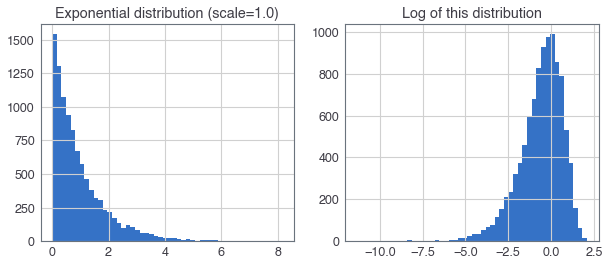

In [109]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The distribution we used for `C` looks quite different: the scale of the samples is picked from a uniform distribution within a given range, which is why the right graph, which represents the log of the samples, looks roughly constant. This distribution is useful when you don't have a clue of what the target scale is:

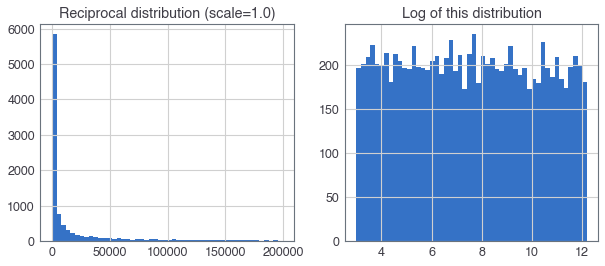

In [110]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The reciprocal distribution is useful when you have no idea what the scale of the hyperparameter should be (indeed, as you can see on the figure on the right, all scales are equally likely, within the given range), whereas the exponential distribution is best when you know (more or less) what the scale of the hyperparameter should be.

### 3.

Question: Try adding a transformer in the preparation pipeline to select only the most important attributes.

In [111]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

Note: this feature selector assumes that you have already computed the feature importances somehow (for example using a `RandomForestRegressor`). You may be tempted to compute them directly in the `TopFeatureSelector`'s `fit()` method, however this would likely slow down grid/randomized search since the feature importances would have to be computed for every hyperparameter combination (unless you implement some sort of cache).

Let's define the number of top features we want to keep:

In [112]:
k = 5

Now let's look for the indices of the top k features:

In [113]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  7,  9, 10, 12])

In [114]:
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'median_income', 'pop_per_hhold', 'bedrooms_per_room',
       'INLAND'], dtype='<U18')

Let's double check that these are indeed the top k features:

In [115]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.32213997124919064, 'median_income'),
 (0.14331671714782468, 'INLAND'),
 (0.10472644407155472, 'pop_per_hhold'),
 (0.08512568956160352, 'bedrooms_per_room'),
 (0.07738847110647139, 'longitude')]

Looking good... Now let's create a new pipeline that runs the previously defined preparation pipeline, and adds top k feature selection:

In [116]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [117]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

Let's look at the features of the first 3 instances:

In [118]:
housing_prepared_top_k_features[0:3]

array([[-1.15604281, -0.61493744, -0.08649871,  0.15531753,  0.        ],
       [-1.17602483,  1.33645936, -0.03353391, -0.83628902,  0.        ],
       [ 1.18684903, -0.5320456 , -0.09240499,  0.4222004 ,  0.        ]])

Now let's double check that these are indeed the top k features:

In [119]:
housing_prepared[0:3, top_k_feature_indices]

array([[-1.15604281, -0.61493744, -0.08649871,  0.15531753,  0.        ],
       [-1.17602483,  1.33645936, -0.03353391, -0.83628902,  0.        ],
       [ 1.18684903, -0.5320456 , -0.09240499,  0.4222004 ,  0.        ]])

### 4.

Question: Try creating a single pipeline that does the full data preparation plus the final
prediction.

In [120]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [121]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(memory=None,
         steps=[('preparation',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                              

Let's try the full pipeline on a few instances:

In [122]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [185384.13066634 341000.56131537 172531.39955817  56040.55006167]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0]


Well, the full pipeline seems to work fine. Of course, the predictions are not fantastic: they would be better if we used the best `RandomForestRegressor` that we found earlier, rather than the best `SVR`.

### 5.

Question: Automatically explore some preparation options using GridSearchCV.

In [123]:
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   8.5s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s remaining:    0.0s


[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   8.7s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   8.6s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   8.4s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   8.5s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=median, total=   9.5s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=median, total=  10.7s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__

[CV]  feature_selection__k=4, preparation__num__imputer__strategy=median, total=  17.4s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=median, total=  11.7s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=median, total=   9.9s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=most_frequent, total=   9.6s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=most_frequent, total=  10.3s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=most_frequent, total=  13.5s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=

[CV]  feature_selection__k=7, preparation__num__imputer__strategy=most_frequent, total=  12.9s
[CV] feature_selection__k=7, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=7, preparation__num__imputer__strategy=most_frequent, total=  12.2s
[CV] feature_selection__k=7, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=7, preparation__num__imputer__strategy=most_frequent, total=  13.7s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=8, preparation__num__imputer__strategy=mean, total=  15.2s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=8, preparation__num__imputer__strategy=mean, total=  14.7s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=8, preparation__num__imputer__strategy=mean, total=  16.7s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature

[CV]  feature_selection__k=11, preparation__num__imputer__strategy=mean, total=  30.8s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=mean, total=  32.2s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=mean, total=  34.4s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=median, total=  34.6s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=median, total=  24.7s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=median, total=  28.0s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, p

[CV]  feature_selection__k=14, preparation__num__imputer__strategy=median, total=  37.3s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=median, total=  59.6s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=median, total=  36.0s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=most_frequent, total=  40.3s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=most_frequent, total=  32.8s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=most_frequent, total=  35.3s
[CV] feature_selection__k=14, preparation__num__impute

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 96.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                     

In [124]:
grid_search_prep.best_params_

{'feature_selection__k': 15,
 'preparation__num__imputer__strategy': 'most_frequent'}

The best imputer strategy is `most_frequent` and apparently almost all features are useful (15 out of 16). The last one (`ISLAND`) seems to just add some noise.